In [151]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

from sklearn import preprocessing
import datetime

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

import seaborn as sns

from datetime import timedelta
from pylab import rcParams

from xgboost import plot_tree
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

## Trabajaremos con la estación MGH

In [265]:
data_MGH_18 = pd.read_csv('/Users/danielbustillos/Desktop/merge_cont_2018.csv')
data_MGH_17 = pd.read_csv('/Users/danielbustillos/Desktop/merge_cont_2017.csv')
data_MGH_16 = pd.read_csv('/Users/danielbustillos/Desktop/merge_cont_2016.csv')
data_MGH_15 = pd.read_csv('/Users/danielbustillos/Desktop/merge_cont_2015.csv')
data_MGH_14 = pd.read_csv('/Users/danielbustillos/Desktop/merge_cont_2014.csv')
data_MGH_13 = pd.read_csv('/Users/danielbustillos/Desktop/merge_cont_2013.csv')
data_MGH_12 = pd.read_csv('/Users/danielbustillos/Desktop/merge_cont_2012.csv')

In [266]:
data_MGH_18 = data_MGH_18.append(data_MGH_17, ignore_index=True)
data_MGH_18 = data_MGH_18.append(data_MGH_16, ignore_index=True)
data_MGH_18 = data_MGH_18.append(data_MGH_16, ignore_index=True)
data_MGH_18 = data_MGH_18.append(data_MGH_15, ignore_index=True)
#data_MGH_18 = data_MGH_18.append(data_MGH_14, ignore_index=True)
data_MGH_18 = data_MGH_18.append(data_MGH_13, ignore_index=True)
data_MGH_18 = data_MGH_18.append(data_MGH_12, ignore_index=True)
data = data_MGH_18

In [267]:
data = data_MGH_18

In [268]:
data = data.rename(columns={'date': 'fecha', 'month': 'mes','hour': 'hora'})


In [269]:
data['dia'] = data['fecha'].astype(str).str[8:10]
data['mes'] =  data['fecha'].astype(str).str[5:7]

In [270]:
data['fecha'] = data['fecha'].astype(str).str[0:10]

In [537]:
data_18 = data[data["id_station"]=="MGH"]
data_18 = data
data_18 = data_18.drop(["Unnamed: 0"],axis=1)
data_18 = data_18.drop_duplicates()
#data = data.drop(["id_station"],axis=1)
data_18 = data_18[["fecha",'mes','dia',"PA", 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM2.5', 'PMCO', 'SO2',
       'RH', 'TMP', 'WSP', 'WDR', 'PM10']]

## Sin promedio


# Promedio Diario

In [998]:
data_hour_merge_24 = data_18


In [999]:
data_18_min = data_hour_merge_24.groupby(['fecha',"mes","dia"])["TMP","PM10","RH","PA"].min()
data_18_min.reset_index(inplace=True)

In [1000]:
data_18_max = data_18.groupby(['fecha',"mes","dia"])["TMP","PM10","RH","PA"].max()
data_18_max.reset_index(inplace=True)

In [1001]:
data_mean = data_18.groupby(['fecha',"mes","dia"]).mean()
data_mean.reset_index(inplace=True)

In [1002]:
data_hour_merge_24 = pd.merge(data_18_min, data_18_max, on=["fecha","mes","dia"])
data_hour_merge_24 = pd.merge(data_hour_merge_24, data_mean, on=["fecha","mes","dia"])

In [1003]:
data_hour_merge_24 = data_hour_merge_24[data_hour_merge_24.PM10_y<200]

In [1004]:
data_hour_merge_24["PM10_1"] = data_hour_merge_24.PM10_y.shift(1)
data_hour_merge_24["PM10_1_a"] = data_hour_merge_24.PM10.shift(-1)
data_hour_merge_24["PM10_2_a"] = data_hour_merge_24.PM10.shift(-2)
data_hour_merge_24["PM10_3_a"] = data_hour_merge_24.PM10.shift(-3)
data_hour_merge_24["PM10_4_a"] = data_hour_merge_24.PM10.shift(-4)

data_hour_merge_24["PM10_2_y"] = data_hour_merge_24.PM10_y.shift(-2)
data_hour_merge_24["PM10_3_y"] = data_hour_merge_24.PM10_y.shift(-3)
data_hour_merge_24["PM10_4_y"] = data_hour_merge_24.PM10_y.shift(-4)


data_hour_merge_24["PM10_24"] = data_hour_merge_24.PM10_y.shift(-1)
data_hour_merge_24["PM10_24_x"] = data_hour_merge_24.PM10_x.shift(1)
data_hour_merge_24["temp_24"] = data_hour_merge_24.TMP.shift(-1)
data_hour_merge_24["pre_24"] = data_hour_merge_24.PA.shift(-1)
data_hour_merge_24["RH_24"] = data_hour_merge_24.RH_y.shift(-1)
data_hour_merge_24["RH_24_2"] = data_hour_merge_24.RH_y.shift(-2)
#data_MGH_18 = data_MGH_18.iloc[:,:-6]

In [1005]:
data_hour_merge_24.columns

Index(['fecha', 'mes', 'dia', 'TMP_x', 'PM10_x', 'RH_x', 'PA_x', 'TMP_y',
       'PM10_y', 'RH_y', 'PA_y', 'PA', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM2.5',
       'PMCO', 'SO2', 'RH', 'TMP', 'WSP', 'WDR', 'PM10', 'PM10_1', 'PM10_1_a',
       'PM10_2_a', 'PM10_3_a', 'PM10_4_a', 'PM10_2_y', 'PM10_3_y', 'PM10_4_y',
       'PM10_24', 'PM10_24_x', 'temp_24', 'pre_24', 'RH_24', 'RH_24_2'],
      dtype='object')

In [962]:
data_hour_merge_24 = data_hour_merge_24[[ 'mes', 'dia', 'TMP_x', 'PM10_x', 'RH_x', 'PA_x', 'TMP_y',
       'PM10_y', 'RH_y', 'PA_y', 'PA', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM2.5',
       'PMCO', 'SO2', 'RH', 'TMP', 'WSP', 'WDR', 'PM10', 'PM10_1', 'PM10_1_a',
       'PM10_2_a', 'PM10_3_a', 'PM10_4_a', 'PM10_2_y', 'PM10_3_y', 'PM10_4_y', 'PM10_24_x', 'temp_24', 'pre_24', 'RH_24', 'RH_24_2','PM10_24']]

In [963]:
data_hour_merge_24 = data_hour_merge_24.dropna(how='any')

In [964]:
data_hour_merge_24['dia'] = data_hour_merge_24['dia'].astype(str).astype(float)
data_hour_merge_24['mes'] = data_hour_merge_24['mes'].astype(str).astype(float)

In [1006]:
data_hour_merge_24.head()

,fecha,mes,dia,TMP_x,PM10_x,RH_x,PA_x,TMP_y,PM10_y,RH_y,...,PM10_4_a,PM10_2_y,PM10_3_y,PM10_4_y,PM10_24,PM10_24_x,temp_24,pre_24,RH_24,RH_24_2
1,2012-01-02,01,02,8.3,5.0,53.0,590.0,13.9,39.0,71.0,...,84.166667,112.0,85.0,176.0,87.0,NaN,11.470000,589.600000,69.0,82.0
2,2012-01-03,01,03,7.1,23.0,35.0,587.0,16.4,87.0,69.0,...,58.625000,85.0,176.0,95.0,112.0,5.0,12.808333,587.375000,82.0,60.0
3,2012-01-04,01,04,5.7,39.0,27.0,585.0,20.1,112.0,82.0,...,57.045455,176.0,95.0,129.0,85.0,23.0,13.683333,586.000000,60.0,63.0
4,2012-01-05,01,05,8.4,38.0,27.0,584.0,19.6,85.0,60.0,...,59.750000,95.0,129.0,99.0,176.0,39.0,14.441667,585.458333,63.0,61.0
6,2012-01-07,01,07,8.0,59.0,17.0,584.0,20.9,176.0,63.0,...,52.750000,129.0,99.0,105.0,95.0,38.0,15.162500,585.041667,61.0,58.0


## Visualizaciones    <a class="anchor" id="viz-bullet"></a>

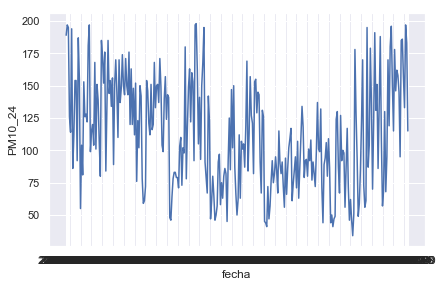

In [1011]:
>>> import seaborn as sns; sns.set()
>>> import matplotlib.pyplot as plt
>>> fmri = sns.load_dataset("fmri")
>>> ax = sns.lineplot(x="fecha", y="PM10_24", data=data_hour_merge_24[data_hour_merge_24.fecha > "2018-01-01"])

## PM10

# O3

ValueError: Could not interpret input 'hora'

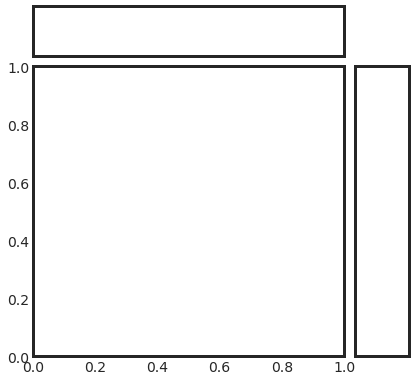

In [288]:
with sns.axes_style('white'):
    sns.jointplot("hora", "O3", data_18);
    plt.savefig('/Users/danielbustillos/Desktop/hora-o3.png', dpi=400,background="white")

In [ ]:
with sns.axes_style('white'):
    sns.jointplot("dia", "O3", data_18);
    plt.savefig('/Users/danielbustillos/Desktop/dia-o3.png', dpi=400,background="white")

/Users/danielbustillos/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


TypeError: can't multiply sequence by non-int of type 'float'

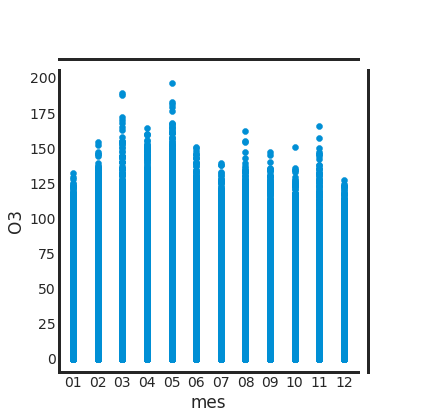

In [289]:
with sns.axes_style('white'):
    sns.jointplot("mes", "O3", data_18);
    plt.savefig('/Users/danielbustillos/Desktop/mes-o3.png', dpi=400,background="white")

In [ ]:
g = sns.PairGrid(data_18, vars=['CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10'], dropna=True)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);

In [ ]:
g = sns.PairGrid(data_18, vars=['PM2.5', 'PMCO', 'SO2','TMP', 'WSP', 'PM10'], dropna=True)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);

ValueError: color kwarg must have one color per data set. 147310 data sets and 1 colors were provided

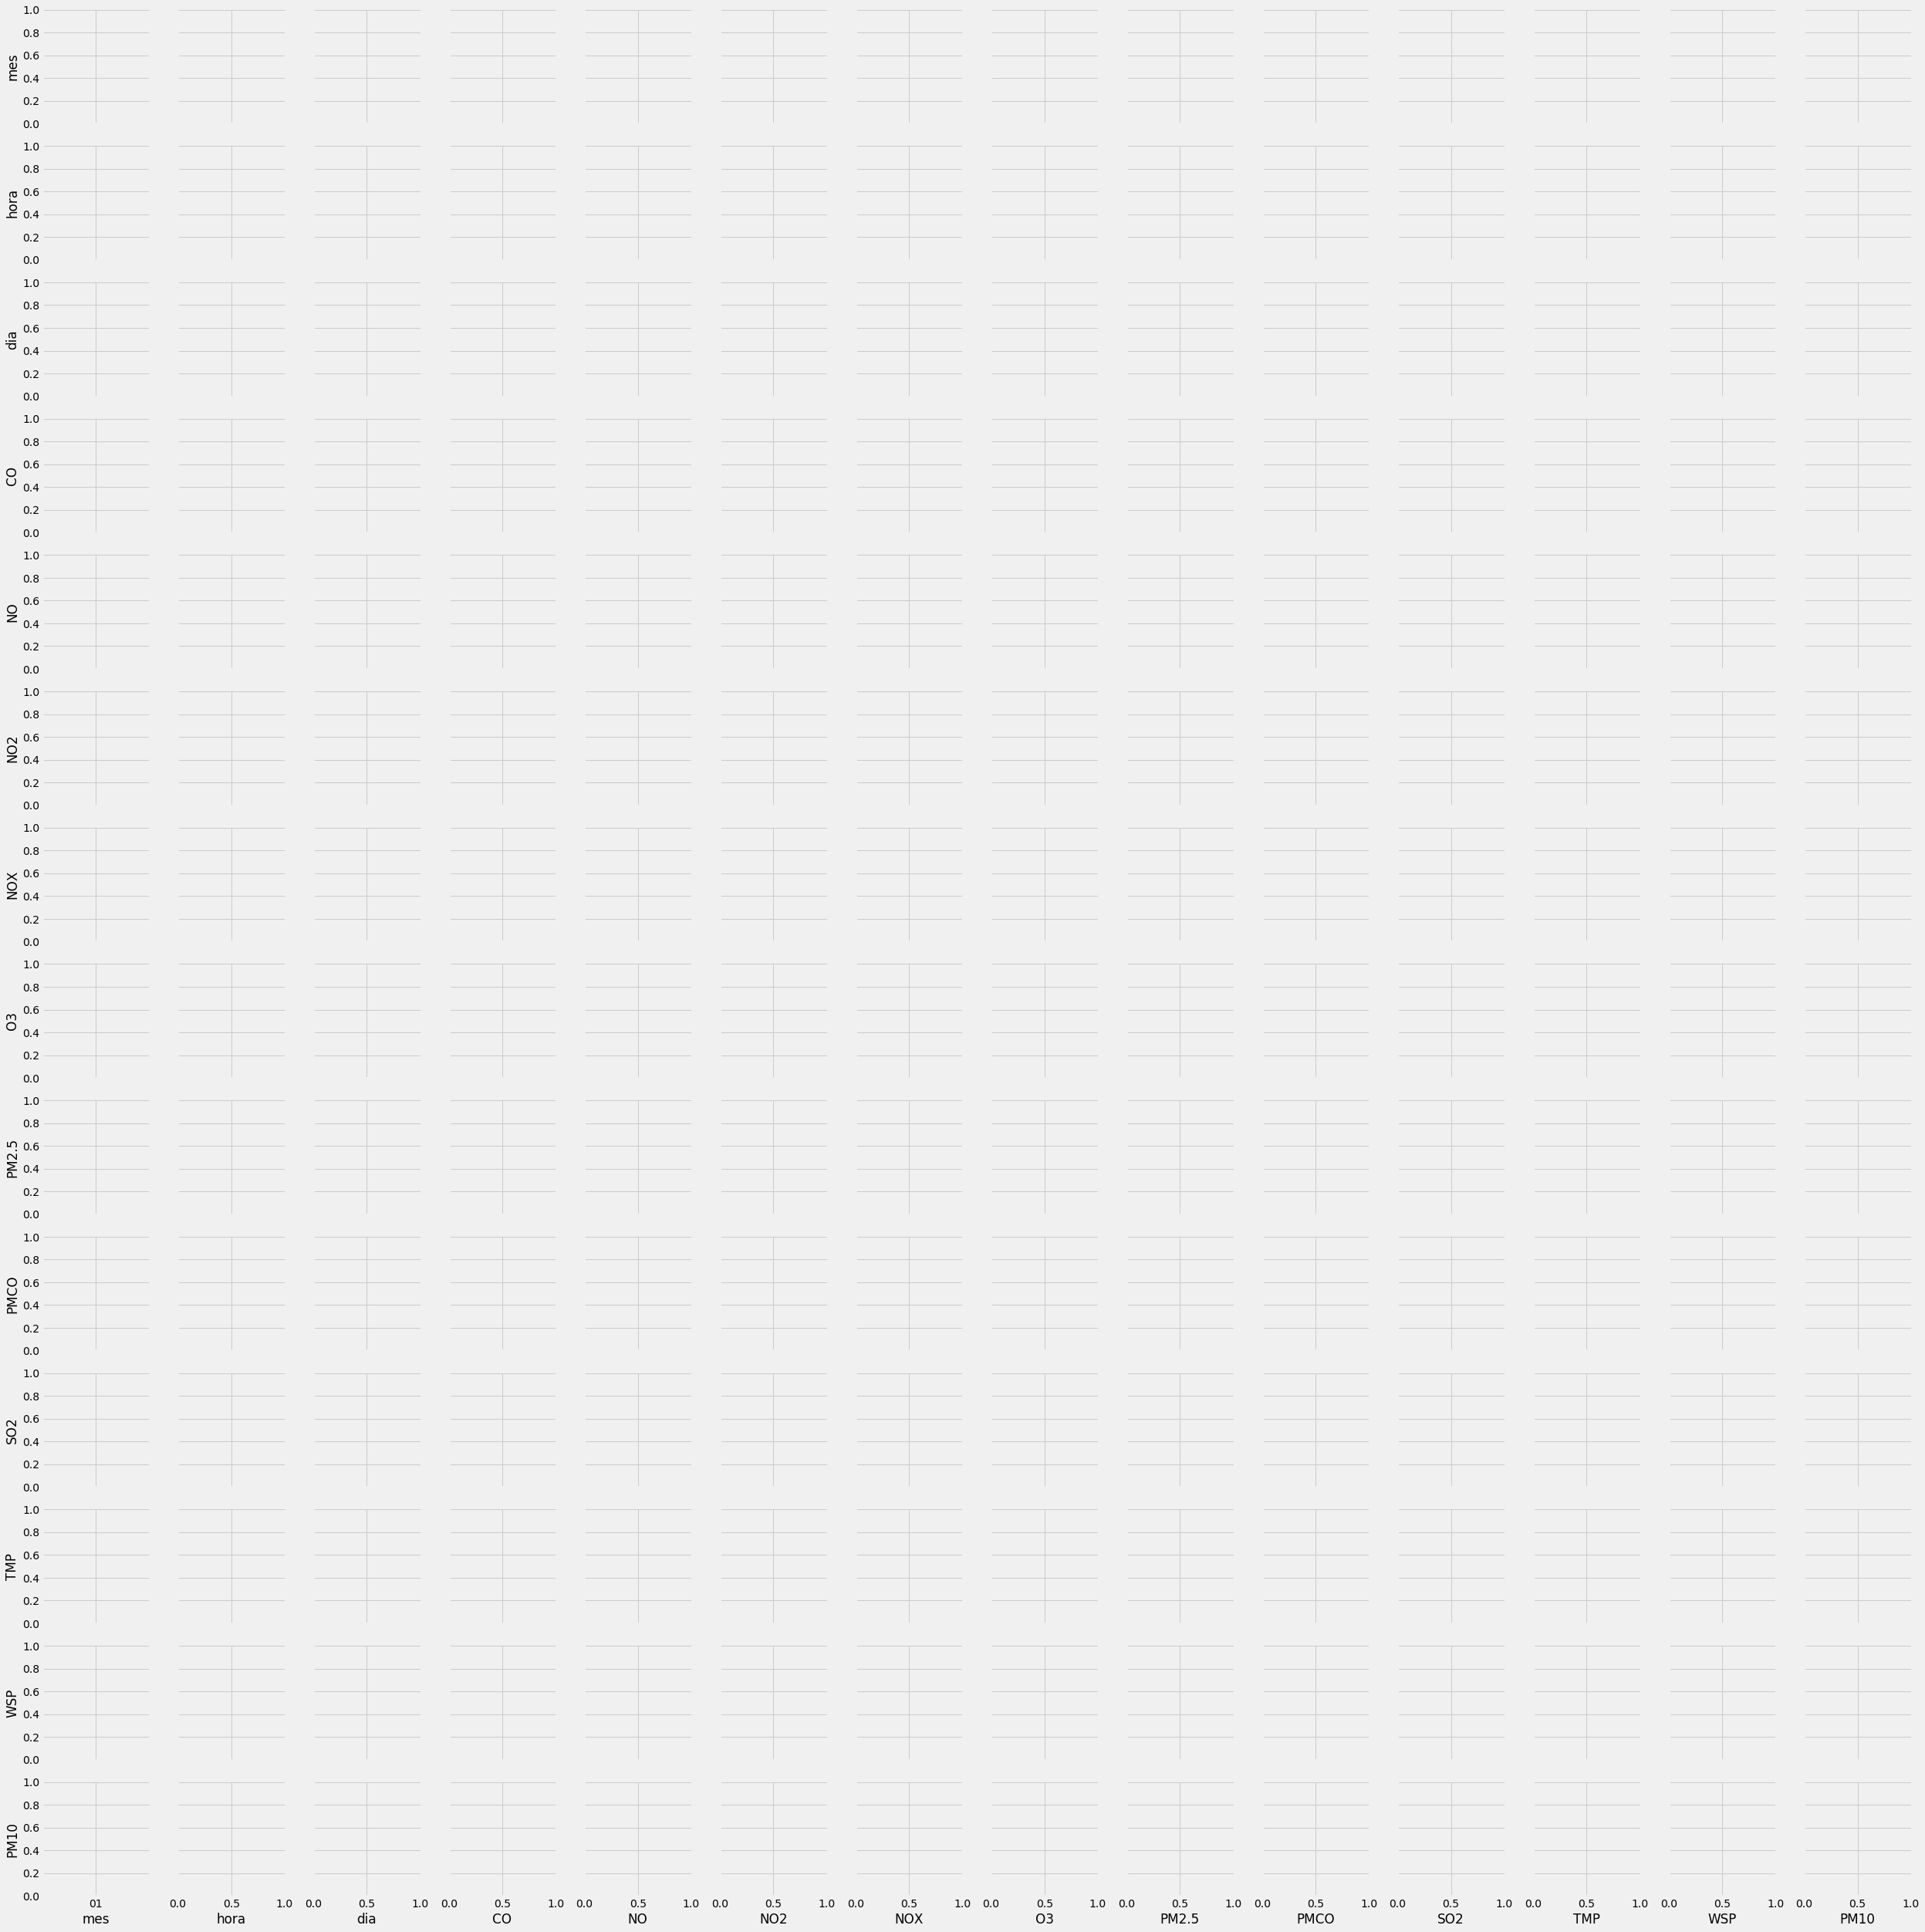

In [290]:
g = sns.PairGrid(data_18, vars=['mes', 'hora',"dia",'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM2.5', 'PMCO', 'SO2','TMP', 'WSP', 'PM10'], dropna=True)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);

## Detalle

In [ ]:
g = sns.PairGrid(data_18, vars=['RH',
       'TMP', 'WSP', 'PM10'], dropna=True)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);


# XGBOOST <a class="anchor" id="fourth-bullet"></a>

## Filtros

## Definimos los conjuntos de prueba y Test

## Delay 24 Horas<a class="anchor" id="5-bullet"></a>
### XGBOOOST

In [966]:
X, y = data_hour_merge_24.iloc[:,:-1],data_hour_merge_24.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

## SVM - Regresión

In [790]:
data_24 = data_hour_merge_24

In [791]:
data_24.head()

,mes,dia,TMP_x,PM10_x,RH_x,PA_x,TMP_y,PM10_y,RH_y,PA_y,...,PM10_1,PM10_1_a,PM10_2_a,PM10_3_a,PM10_4_a,PM10_24_x,temp_24,pre_24,RH_24,PM10_24
2,1.0,3.0,7.1,23.0,35.0,587.0,16.4,87.0,69.0,592.0,...,39.0,70.875000,60.541667,84.166667,58.625000,5.0,12.808333,587.375000,82.0,112.0
3,1.0,4.0,5.7,39.0,27.0,585.0,20.1,112.0,82.0,589.0,...,87.0,60.541667,84.166667,58.625000,57.045455,23.0,13.683333,586.000000,60.0,85.0
4,1.0,5.0,8.4,38.0,27.0,584.0,19.6,85.0,60.0,588.0,...,112.0,84.166667,58.625000,57.045455,59.750000,39.0,14.441667,585.458333,63.0,176.0
6,1.0,7.0,8.0,59.0,17.0,584.0,20.9,176.0,63.0,587.0,...,85.0,58.625000,57.045455,59.750000,52.750000,38.0,15.162500,585.041667,61.0,95.0
7,1.0,8.0,8.9,30.0,20.0,583.0,23.1,95.0,61.0,587.0,...,176.0,57.045455,59.750000,52.750000,68.300000,59.0,15.172727,585.000000,58.0,129.0


In [792]:
clf = SVR(gamma='scale' , C=100000.0, epsilon=50)
clf.fit(X_train, y_train)

SVR(C=100000.0, cache_size=200, coef0=0.0, degree=3, epsilon=50,
  gamma='scale', kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)

In [755]:
preds_test = clf.predict(X_test)

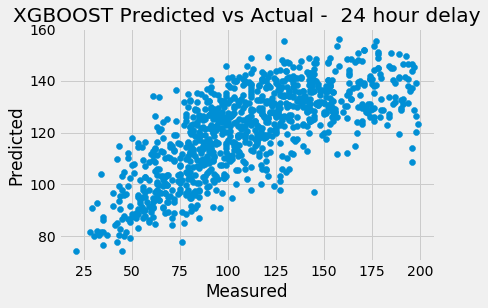

In [756]:
plt.scatter(y_test, preds_test)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('XGBOOST Predicted vs Actual -  24 hour delay')
plt.show()

In [757]:
clf.score(X_test, y_test)

0.3696802715712452

In [758]:
rmse = np.sqrt(mean_squared_error(y_test, preds_test))
print("RMSE: %f" % (rmse))

RMSE: 30.741184


## Linear

In [759]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create linear regression object
regr = LinearRegression()

In [760]:
# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [761]:
# Make predictions using the testing set
lin_pred = regr.predict(X_test)

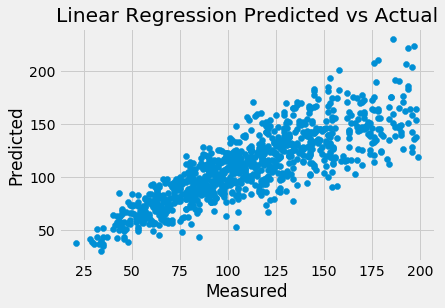

In [762]:
plt.scatter(y_test, lin_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Linear Regression Predicted vs Actual')
plt.show()

In [763]:
regr.score(X_test, y_test)

0.6908202173920476

## Neural Network Regression

In [976]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create MLPRegressor object
mlp = MLPRegressor( alpha=900.001, max_iter=100000,power_t=301, epsilon=.100 ,tol=.0001)
# Train the model using the training sets
mlp.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=900.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=0.1,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=301,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

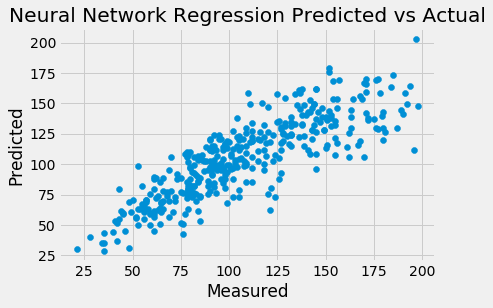

In [977]:
# Score the model
neural_network_regression_score = mlp.score(X_test, y_test)
neural_network_regression_score
# Make predictions using the testing set
nnr_pred = mlp.predict(X_test)
# The mean squared error

plt.scatter(y_test, nnr_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Neural Network Regression Predicted vs Actual')
plt.show()

In [978]:
xgb_score = mlp.score(X_test, y_test)
xgb_score

0.7057081794006173

# XGBoost

In [767]:
from xgboost.sklearn import XGBRegressor

#Fitting XGB regressor 
xboost = XGBRegressor(learning_rate = .0015, n_estimators=3000, max_depth=10)

In [939]:
xboost.fit(X_train, y_train)
xgb_score = xboost.score(X_test, y_test)

/Users/danielbustillos/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.708041865321613

In [940]:
#Predict 
xboost_pred = xboost.predict(X_test)

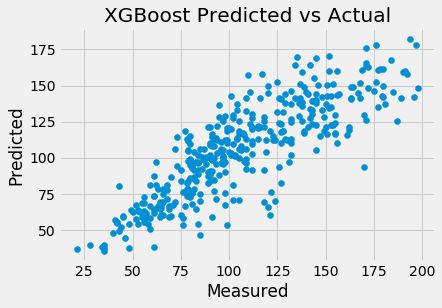

In [941]:
plt.scatter(y_test, xboost_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('XGBoost Predicted vs Actual')
plt.show()

In [771]:
xgb_score = xboost.score(X_test, y_test)
xgb_score

0.6586242418487962

## Decission Tree

In [772]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=10,max_depth=3000)

In [773]:
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3000, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=10, splitter='best')

In [774]:

regressor_score = xboost.score(X_test, y_test)
regressor_score

0.6586242418487962

In [775]:
xboost_pred = regressor.predict(X_test)

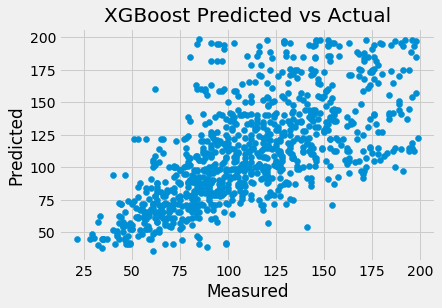

In [776]:
plt.scatter(y_test, xboost_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('XGBoost Predicted vs Actual')
plt.show()

In [777]:
regressor.score(X_test, y_test)

0.31024162969540403

# ada

In [996]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

rng = np.random.RandomState(1)
regr_1 = DecisionTreeRegressor(max_depth=40)
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=40),n_estimators=3000)


X = X_train
y = y_train
regr_1.fit(X, y)
regr_2.fit(X, y)



# Predict
y_1 = regr_1.predict(X_train)
y_2 = regr_2.predict(X_test)


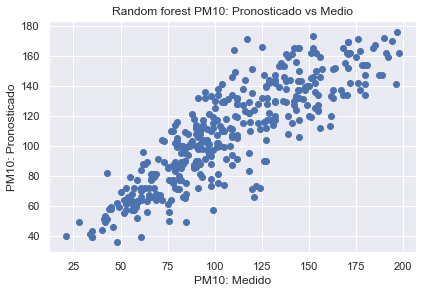

In [1138]:
plt.scatter(y_test, y_2)
plt.tight_layout(1.3)
plt.xlabel('PM10: Medido')
plt.ylabel('PM10: Pronosticado')
plt.title('Random forest PM10: Pronosticado vs Medio')
plt.savefig('/Users/danielbustillos/Desktop/Pem10.png', dpi=900)
plt.show()

In [1113]:
preds == yi

True

In [1114]:
y_1 = regr_1.predict(X_test)


In [ ]:
X, y = data_hour_merge_24.iloc[:,:-1],data_hour_merge_24.iloc[:,-1]

In [1116]:
preds = y_1.tolist()

In [1122]:
yi = y_test.tolist()

In [1123]:
y;

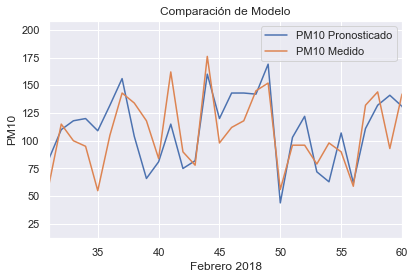

In [1137]:
>>> plt.plot(preds ,label='PM10 Pronosticado')
>>> plt.plot(yi,label='PM10 Medido')
>>> plt.xlabel("Febrero 2018")
>>> plt.ylabel("PM10")
plt.tight_layout(1.3)
plt.title('Comparación de Modelo')
>>> plt.xlim(31, 60)
plt.legend()
plt.savefig('/Users/danielbustillos/Desktop/Pm10.png', dpi=900)





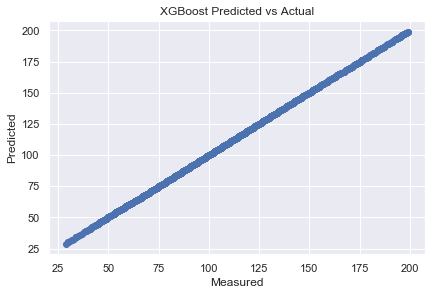

In [1027]:
plt.scatter(y_train, y_1)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('XGBoost Predicted vs Actual')
plt.show()

In [1031]:
rmse = np.sqrt(mean_squared_error(y_test, y_2))
print("RMSE: %f" % (rmse))

RMSE: 19.784592


In [981]:
regr_2.score(X_test, y_test)

0.7367065986222534

## Random forest

In [1040]:
>>> from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

>>> from sklearn.datasets import make_regression

In [1062]:
regr = RandomForestRegressor(max_depth=35,n_estimators=500)
regr_fit = regr.fit(X_train, y_train)

In [1042]:
y_1 = regr.predict(X_test)

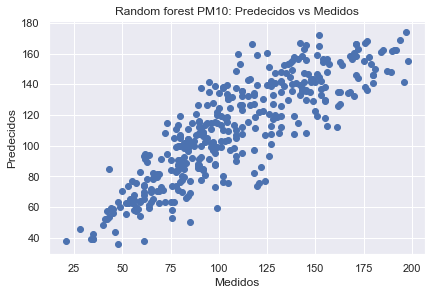

In [1043]:
plt.scatter(y_test, y_1)
plt.xlabel('Medidos')
plt.ylabel('Predecidos')
plt.title('Random forest PM10: Predecidos vs Medidos')
plt.show()

In [1044]:
regr.score(X_test, y_test)

0.7214643804284817

In [1047]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(regr.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

In [1053]:
importances[importances.importance > .01]

,importance
feature,
PM10_1_a,0.653
pre_24,0.047
PA_x,0.016
PM10_y,0.015
PA,0.013
PM10_2_y,0.012
TMP,0.012
WDR,0.011


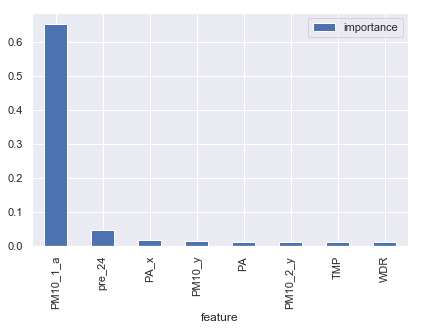

In [1054]:
importances[importances.importance > .01].plot.bar()
